In [7]:
import robot_plotter as rp
import models_functions as mf
import traj
import numpy as np
import matplotlib.pyplot as plt
import robot_sim as sim

## Script for running many simulations of a particular trajectory
Run many simulations with set random seeds, for use with ANEES purposes. 

This one is for Luft et al's implementation of the CL algorithm

In [8]:
# generate reference trajectory
dt = 0.01
xa1 = np.zeros((mf.STATE_LEN, 1)); xa1[:6] = np.array([[-1.57],[0],[0.5],[5],[0.1],[-0.1]])
xb1 = np.zeros((mf.STATE_LEN, 1)); xb1[:6] = np.array([[0],[0],[6],[6.5],[0.2],[0]])
xc1 = np.zeros((mf.STATE_LEN, 1)); xc1[:6] = np.array([[-1.57],[0],[9.5],[4],[0],[-0.1]])

pos1, y_IMU1_base = traj.gen_poly_traj_multi(pos=[xa1, xb1, xc1], time=[0, 30, 60], dt=dt)

xa2 = np.zeros((mf.STATE_LEN, 1)); xa2[:6] = np.array([[0],[0],[0.5],[3],[0.1],[0]])
xb2 = np.zeros((mf.STATE_LEN, 1)); xb2[:6] = np.array([[3.14],[0],[7],[5],[-0.5],[0]])
xc2 = np.zeros((mf.STATE_LEN, 1)); xc2[:6] = np.array([[-1.57],[0],[3],[0.5],[0],[-0.1]])

pos2, y_IMU2_base = traj.gen_poly_traj_multi(pos=[xa2, xb2, xc2], time=[0, 30, 60], dt=dt)

xa3 = np.zeros((mf.STATE_LEN, 1)); xa3[:6] = np.array([[1.57],[0],[0.5],[0.5],[0],[0.1]])
xb3 = np.zeros((mf.STATE_LEN, 1)); xb3[:6] = np.array([[0],[0],[6],[2],[0],[-0.1]])
xc3 = np.zeros((mf.STATE_LEN, 1)); xc3[:6] = np.array([[-1.57],[0],[9],[3],[0],[0.1]])

pos3, y_IMU3_base = traj.gen_poly_traj_multi(pos=[xa3, xb3, xc3], time=[0, 30, 60], dt=dt)

pos_len = pos1.shape[1] # Assumes that all paths have the same length

# Generate anchors position:
xanc1 = np.zeros((mf.STATE_LEN, 1)); xanc1[:4] = np.array([[-0.7854],[0],[0.1],[6.9]])
xanc2 = np.zeros((mf.STATE_LEN, 1)); xanc2[:4] = np.array([[2.3562],[0],[9.9],[0.1]])

In [9]:
# Generate noise
R_b = 0.0009
R_r = 0.001
R_w = 0.0002
R_a = 0.004

Q=np.diag([0.1, 8.0, 8.0, 0.000001, 0.00001, 0.00001])
R=np.diag([R_b, R_r, R_w, R_a, R_a]) # approx vaules from datasheets
P=np.diag([0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.0004,0.01,0.01]) # Initialize with system noise for bias

anchor1 = sim.Anchor(x0=xanc1)
anchor2 = sim.Anchor(x0=xanc2)


In [10]:
list_seeds = [1000]
#1061, 1, 19001, 72, 621, 8718, 2, 666

x_logL1 = []
P_logL1 = []
x_logL2 = []
P_logL2 = []
x_logL3 = []
P_logL3 = []

for seed in list_seeds:
    print("seed: " + str(seed))
    timu1 = y_IMU1_base.copy()
    timu2 = y_IMU1_base.copy()
    timu3 = y_IMU1_base.copy()

    np.random.seed(seed)
    y_IMU1 = traj.gen_noise(timu1, dt=1, sigma=np.diag([R_w, R_a, R_a]), bias=np.array([[0.00],[0.0],[0.0]]))
    y_IMU2 = traj.gen_noise(timu2, dt=1, sigma=np.diag([R_w, R_a, R_a]), bias=np.array([[0.00],[0.0],[0.0]]))
    y_IMU3 = traj.gen_noise(timu3, dt=1, sigma=np.diag([R_w, R_a, R_a]), bias=np.array([[0.00],[0.0],[0.0]]))

    # Run LUFT algorithm
    robotL1 = sim.robot_luft(x0=xa1, path=pos1, imu=y_IMU1, dt=dt, Q=Q, R=R, P=P, id=111)
    robotL2 = sim.robot_luft(x0=xa2, path=pos2, imu=y_IMU2, dt=dt, Q=Q, R=R, P=P, id=222)
    robotL3 = sim.robot_luft(x0=xa3, path=pos3, imu=y_IMU3, dt=dt, Q=Q, R=R, P=P, id=333)

    np.random.seed(0)
    for i in range(pos_len-1):
        robotL1.predict(imu_correct=True)
        robotL2.predict(imu_correct=True)
        robotL3.predict(imu_correct=True)
        if (i > 0 and i % 100 == 0):
            print(i)
            inno_small = robotL1.anchor_meas(anchor1, sr=R_r, sb=R_b)            
            inno_small = robotL1.anchor_meas(anchor2, sr=R_r, sb=R_b)

            robotL1.robot_meas_luft(robotL2, sr=R_r, sb=R_b)
            robotL2.robot_meas_luft(robotL1, sr=R_r, sb=R_b)

            robotL3.robot_meas_luft(robotL2, sr=R_r, sb=R_b)
            robotL2.robot_meas_luft(robotL3, sr=R_r, sb=R_b)
    
    # Save estimates and covariances:
    x_logL1 += [robotL1.x_log]
    P_logL1 += [robotL1.P_log]
    x_logL2 += [robotL2.x_log]
    P_logL2 += [robotL2.P_log]       
    x_logL3 += [robotL3.x_log]
    P_logL3 += [robotL3.P_log] 


seed: 1000
100
Adding new robot: 111
Adding new robot: 222
Adding new robot: 333
Adding new robot: 222
Wrong measurement used!! Bearing: 4.7220420379954735 was used instead of: -1.5804493844056804
200
300
400
Wrong measurement used!! Bearing: 1.5578655328698434 was used instead of: 1.5837271207199497
500
600
700
800
900
1000
1100
1200
Wrong measurement used!! Bearing: 1.5973819365643 was used instead of: 1.544210717025493
1300
Wrong measurement used!! Bearing: 1.6084043159443915 was used instead of: 1.5331883376454016
1400
1500
1600
1700
1800
Wrong measurement used!! Bearing: 7.863858069491444 was used instead of: -4.722265415901651
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
Wrong measurement used!! Bearing: 4.512968619444949 was used instead of: -1.3713759658551556
Wrong measurement used!! Bearing: 1.758032364812766 was used instead of: 1.383560288777027
3200
Wrong measurement used!! Bearing: 7.822692755878278 was used instead of: -4.681100102288485
3300
Wrong me

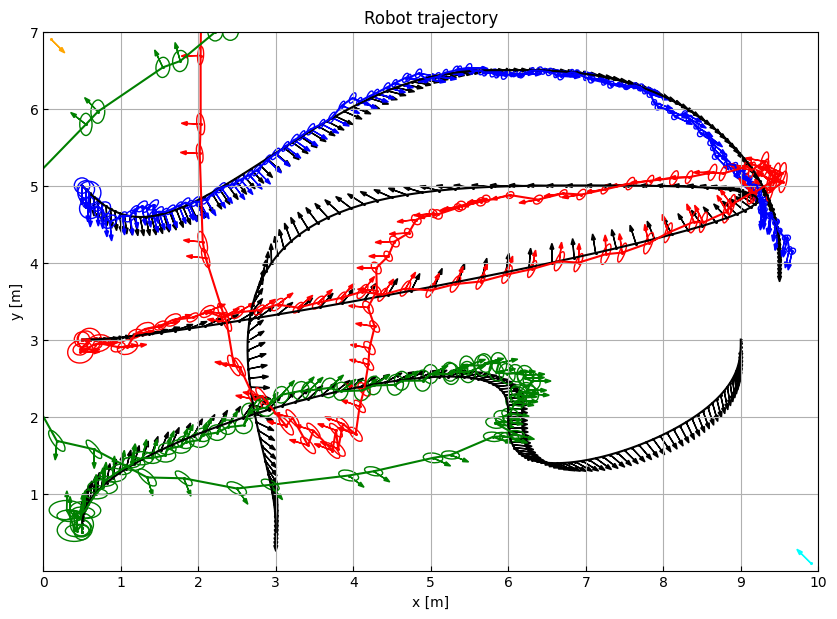

In [11]:
# Plot the choosen simulation:
s_idx = 0

# Plot ground truth
fig, ax = rp.setup_plot()
rp.plot_position(ax, pos1[:,::50], color='black')
rp.plot_position(ax, pos2[:,::50], color='black')
rp.plot_position(ax, pos3[:,::50], color='black')

# Plot states of robots:
rp.plot_position2(ax, x_logL1[s_idx][:,::50], P_logL1[s_idx][:,:,::50], color='blue')
rp.plot_position2(ax, x_logL2[s_idx][:,::50], P_logL2[s_idx][:,:,::50], color='red')
rp.plot_position2(ax, x_logL3[s_idx][:,::50], P_logL3[s_idx][:,:,::50], color='green')

anchor1.draw_position(ax, color='orange')
anchor2.draw_position(ax, color='cyan')

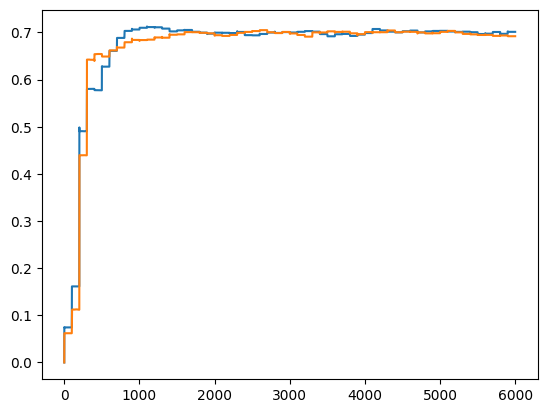

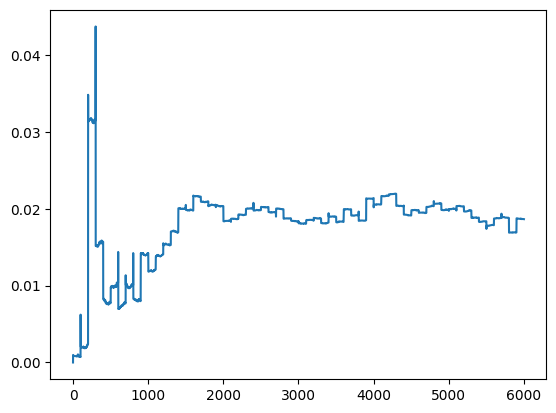

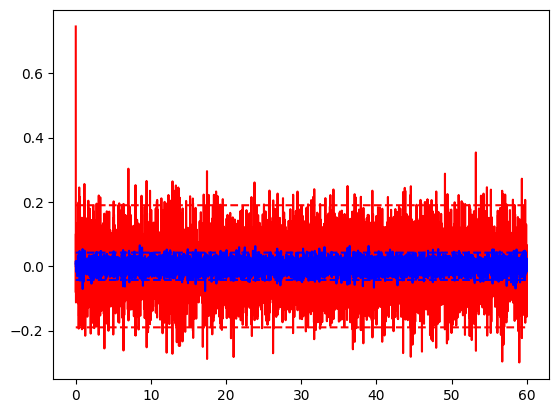

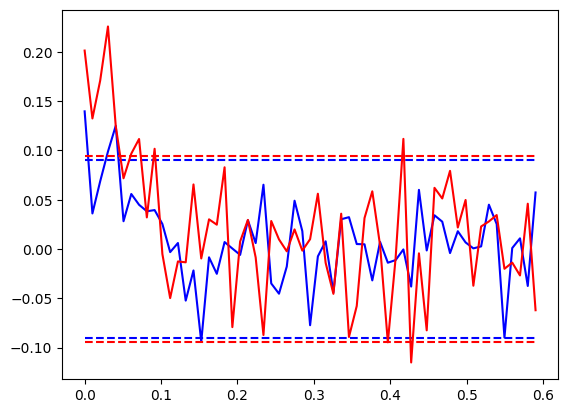

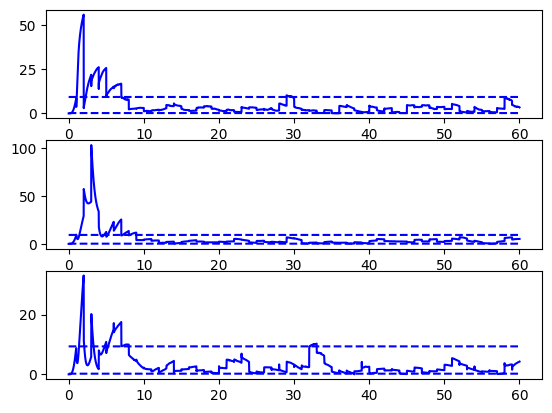

In [ ]:
# Plot metrics:

# Plot the bias states:
x_log2plot = x_logL3
# For acc:
plt.figure()
plt.plot(x_log2plot[9,:])
plt.plot(x_log2plot[10,:])
plt.figure()
plt.plot(x_log2plot[8,:])

# Plot the innovation process of IMU:
fig, ax2 = plt.subplots()
rp.plot_innovation(ax2, inno_log[1,:], R_a, dt=dt, color='red')
rp.plot_innovation(ax2, inno_log[0,:], R_w, dt=dt)
fig, ax3 = plt.subplots()
rp.plot_innovation(ax3, inno_pos2[0,:], R_b, dt=dt)
rp.plot_innovation(ax3, inno_pos2[1,:], R_r, dt=dt, color='red')

# NEES analysis
# If higher than confidence interval, then the estimate is overconfident
fig, axs2 = plt.subplots(3)
pos_ind = [0, 2, 3]
rp.plot_NEES(axs2[0], 
             x_est=x_logL1[pos_ind,:],
             x_true=robotL1.path[:3,:], 
             P=P_logL1[np.ix_(pos_ind, pos_ind)], 
             dt=dt,
             prob=0.95)
rp.plot_NEES(axs2[1], 
             x_est=x_logL2[pos_ind,:],
             x_true=robotL2.path[:3,:], 
             P=P_logL2[np.ix_(pos_ind, pos_ind)], 
             dt=dt,
             prob=0.95)
rp.plot_NEES(axs2[2], 
             x_est=x_logL3[pos_ind,:],
             x_true=robotL3.path[:3,:], 
             P=P_logL3[np.ix_(pos_ind, pos_ind)], 
             dt=dt,
             prob=0.95)

In [ ]:
# Run naive algorithm
# Setup robots and anchors:
robot1 = sim.Robot_single(x0=xa1, path=pos1, imu=y_IMU1, dt=dt, Q=Q, R=R, P=P)
robot2 = sim.Robot_single(x0=xa2, path=pos2, imu=y_IMU2, dt=dt, Q=Q, R=R, P=P)
robot3 = sim.Robot_single(x0=xa3, path=pos3, imu=y_IMU3, dt=dt, Q=Q, R=R, P=P)

np.random.seed(0)
for i in range(pos_len-1):
    robot1.predict()
    robot2.predict()
    robot3.predict()
    if (i > 0 and i % 100 == 0):
        robot1.anchor_meas(anchor1, sr=R_r, sb=R_b)
        robot1.anchor_meas(anchor2, sr=R_r, sb=R_b)

        robot1.robot_meas(robot2, sr=R_r, sb=R_b)
        robot2.robot_meas(robot1, sr=R_r, sb=R_b)

        robot3.robot_meas(robot2, sr=R_r, sb=R_b)
        robot2.robot_meas(robot3, sr=R_r, sb=R_b)
        

Wrong measurement used!! Bearing: 1.583994044960379 was used instead of: 1.557598608629414
Wrong measurement used!! Bearing: 1.6228930225182738 was used instead of: 1.5186996310715193
Wrong measurement used!! Bearing: 1.6016526870456833 was used instead of: 1.5399399665441098
Wrong measurement used!! Bearing: 1.587028223614857 was used instead of: 1.5545644299749362
Wrong measurement used!! Bearing: 1.5973819365643 was used instead of: 1.544210717025493
Wrong measurement used!! Bearing: 7.863858069491444 was used instead of: -4.722265415901651
Wrong measurement used!! Bearing: 1.5392040710775152 was used instead of: 1.602388582512278
Wrong measurement used!! Bearing: 4.7082989123924595 was used instead of: -1.5667062588026661
Wrong measurement used!! Bearing: 1.611143336908697 was used instead of: 1.5304493166810962


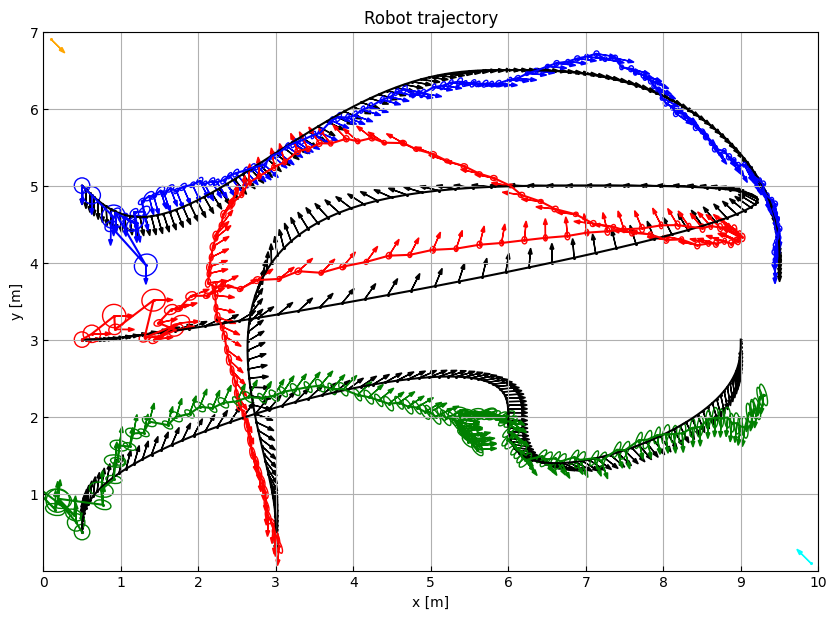

In [ ]:
# Plot the quantuties we have logged:
x_log1 = robot1.x_log
P_log1 = robot1.P_log
x_log2 = robot2.x_log
P_log2 = robot2.P_log       
x_log3 = robot3.x_log
P_log3 = robot3.P_log 

# Plot ground truth
fig, ax = rp.setup_plot()
rp.plot_position(ax, pos1[:,::50], color='black')
rp.plot_position(ax, pos2[:,::50], color='black')
rp.plot_position(ax, pos3[:,::50], color='black')

# Plot states of robots:
rp.plot_position2(ax, x_log1[:,::50], P_log1[:,:,::50], color='blue')
rp.plot_position2(ax, x_log2[:,::50], P_log2[:,:,::50], color='red')
rp.plot_position2(ax, x_log3[:,::50], P_log3[:,:,::50], color='green')

# Plot anchors
anchor1.draw_position(ax, color='orange')
anchor2.draw_position(ax, color='cyan')

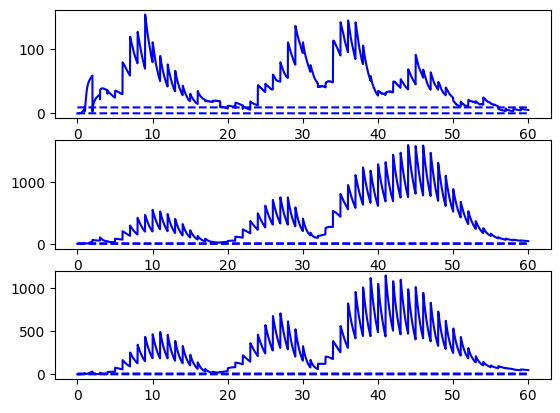

In [ ]:
# NEES analysis
# If higher than confidence interval, then the estimate is overconfident
fig, axs = plt.subplots(3)
pos_ind = [0, 2, 3]
rp.plot_NEES(axs[0], 
             x_est=x_log1[pos_ind,:],
             x_true=robot1.path[:3,:], 
             P=P_log1[np.ix_(pos_ind, pos_ind)], 
             dt=dt,
             prob=0.95)
rp.plot_NEES(axs[1], 
             x_est=x_log2[pos_ind,:],
             x_true=robot2.path[:3,:], 
             P=P_log2[np.ix_(pos_ind, pos_ind)], 
             dt=dt,
             prob=0.95)
rp.plot_NEES(axs[2], 
             x_est=x_log3[pos_ind,:],
             x_true=robot3.path[:3,:], 
             P=P_log3[np.ix_(pos_ind, pos_ind)], 
             dt=dt,
             prob=0.95)

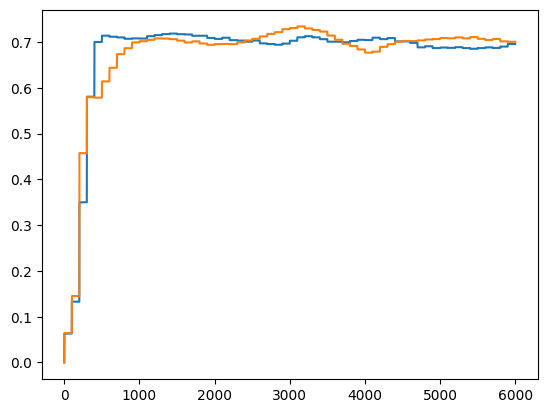

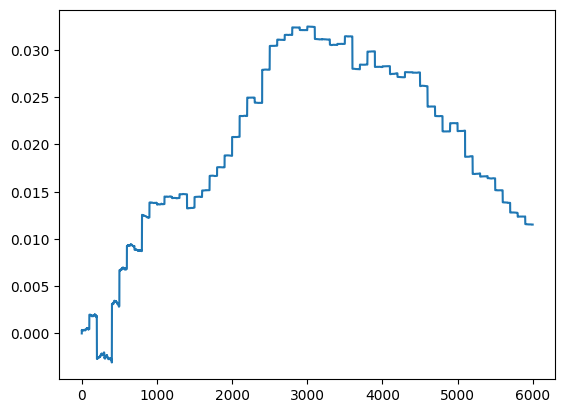

In [ ]:
# Plot bias states:
# For acc:
plt.figure()
plt.plot(x_log2[9,:])
plt.plot(x_log2[10,:])
plt.figure()
plt.plot(x_log2[8,:])